In [1]:
import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import matplotlib.pyplot as plt

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST
from torchvision.datasets import CIFAR10
from torchvision import transforms


from torchinfo import summary
torch.cuda.empty_cache()

np.random.seed(0)
torch.manual_seed(0)

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")
torch.cuda.empty_cache()

Using cuda device


In [3]:
# create dataset
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.datasets as datasets


class dawtaset(Dataset):
    def __init__(self, image_path, transform=None, featureExtraction=None):
        super(dawtaset, self).__init__()
        self.image_folder = datasets.ImageFolder(image_path)
        self.data_classes = self.image_folder
        self.transform = transform
        self.featureExtraction = featureExtraction
    def __len__(self):
        return len(self.image_folder)
    
    def __getitem__(self, idx):
        image, label = self.image_folder[idx]
        classes = self.data_classes.classes[label]
        path = self.image_folder.imgs[idx][0]
        data = self.image_folder
        # Apply transformations (if needed)
        if self.transform:
            image = self.transform(image)
        
        varReturn = {
            "image": image,
            "label": label,
            "classes": classes,
            
        }
        
        
        
        return varReturn

In [4]:
from torch.utils.data import DataLoader, TensorDataset

train_transform = transforms.Compose([
    #  transforms.RandomRotation(degrees=(30, 70)),
    transforms.Resize((100, 100)),
    # transforms.Grayscale(1),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.5),
    # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
   
    transforms.ToTensor(),
   
])
dataset = dawtaset(image_path="../../../dataset/SIBI/SIBI_datasets_LEMLITBANG_SIBI_R_90.10_RAW/SIBI_datasets_LEMLITBANG_SIBI_R_90.10_RAW/training/", transform=train_transform)

print(type(dataset))

<class '__main__.dawtaset'>


In [5]:
from torch.utils.data import DataLoader, random_split
BATCH_SIZE = 32
image_path="../../../dataset/SIBI/SIBI_datasets_LEMLITBANG_SIBI_R_90.10_RAW/SIBI_datasets_LEMLITBANG_SIBI_R_90.10_RAW/validation/"
# split dataset
# train_data, val_data = random_split(dataset, [0.80, 0.20])
data_val = dawtaset(image_path=image_path, transform=train_transform)

train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_dataloader = DataLoader(data_val, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

    


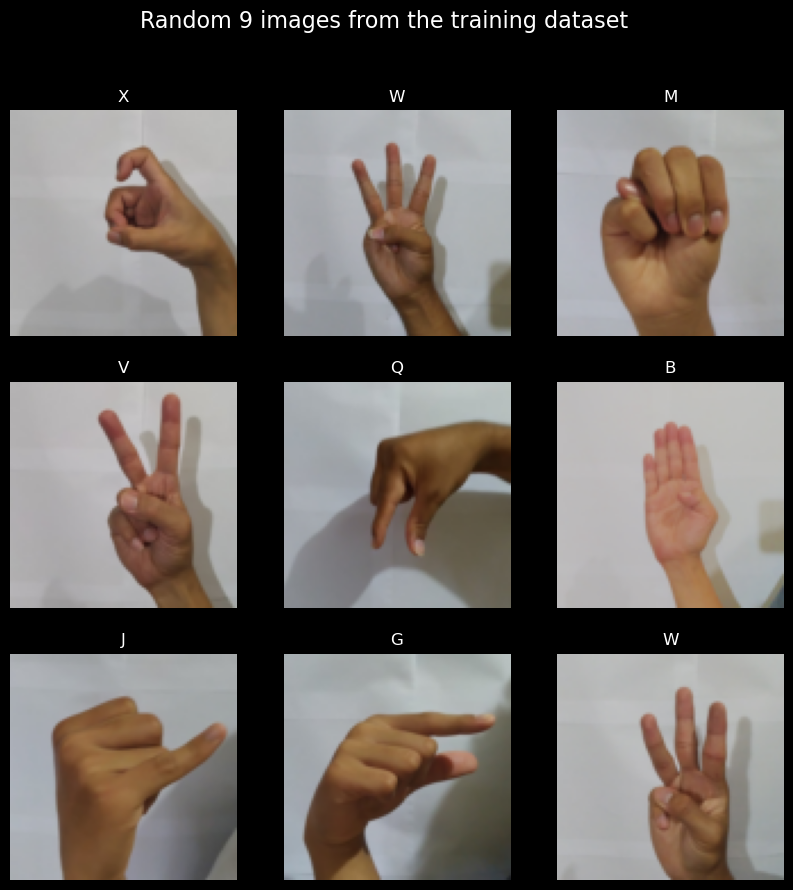

In [6]:
import matplotlib.pyplot as plt
import random

num_rows = 3
num_cols = num_rows

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))

# Iterate over the subplots and display random images from the training dataset
for i in range(num_rows):
    for j in range(num_cols):
        # Choose a random index from the training dataset
        image_index = random.randrange(len(dataset))

        # Display the image in the subplot
        # print(training_dataset[image_index])
        axs[i, j].imshow(dataset[image_index]['image'].permute((1, 2, 0)))

        # Set the title of the subplot as the corresponding class name
        axs[i, j].set_title(dataset[image_index]['classes'], color="white")

        # Disable the axis for better visualization
        axs[i, j].axis(False)

# Set the super title of the figure
fig.suptitle(f"Random {num_rows * num_cols} images from the training dataset", fontsize=16, color="white")

# Set the background color of the figure as black
fig.set_facecolor(color='black')

# Display the plot
plt.show()

In [7]:
import timm

PATCH_SIZE = 10
IMAGE_WIDTH = 50
IMAGE_HEIGHT = IMAGE_WIDTH
IMAGE_CHANNELS = 32
EMBEDDING_DIMS = IMAGE_CHANNELS * PATCH_SIZE**2
NUM_OF_PATCHES = int((IMAGE_WIDTH * IMAGE_HEIGHT) / PATCH_SIZE**2)

print(EMBEDDING_DIMS)

BATCH_SIZE = 32
class PatchEmbeddingLayer(nn.Module):
    def __init__(self, in_channels, patch_size, embedding_dim,):
        super().__init__()
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.in_channels = in_channels
        self.conv_layer = nn.Conv2d(in_channels=32, out_channels=embedding_dim, kernel_size=patch_size, stride=patch_size)
        

        self.flatten_layer = nn.Flatten(start_dim=1, end_dim=2)
        self.class_token_embeddings = nn.Parameter(torch.rand((BATCH_SIZE, 1, EMBEDDING_DIMS), requires_grad=True))
        self.position_embeddings = nn.Parameter(torch.rand((1, NUM_OF_PATCHES + 1, EMBEDDING_DIMS), requires_grad=True))

    def forward(self, x):
        # print(self.class_token_embeddings.shape)
        # print(self.flatten_layer(self.conv_layer(x).permute((0, 2, 3, 1))).shape)
        # print(self.position_embeddings.shape)
        output = torch.cat((self.class_token_embeddings, self.flatten_layer(self.conv_layer(x).permute((0, 2, 3, 1)))), dim=1) + self.position_embeddings
        # print(output.shape)
        return output

class MultiHeadSelfAttentionBlock(nn.Module):
  def __init__(self,
               embedding_dims, # Hidden Size D in the ViT Paper Table 1
               num_heads,  # Heads in the ViT Paper Table 1
               attn_dropout # Default to Zero as there is no dropout for the the MSA Block as per the ViT Paper
               ):
    super().__init__()

    self.embedding_dims = embedding_dims
    self.num_head = num_heads
    self.attn_dropout = attn_dropout

    self.layernorm = nn.LayerNorm(normalized_shape = embedding_dims)

    self.multiheadattention =  nn.MultiheadAttention(num_heads = num_heads,
                                                     embed_dim = embedding_dims,
                                                     dropout = attn_dropout,
                                                     batch_first = True,
                                                    )

  def forward(self, x):
    x = self.layernorm(x)
    output,_ = self.multiheadattention(query=x, key=x, value=x,need_weights=False)
    return output



class MachineLearningPerceptronBlock(nn.Module):
  def __init__(self, embedding_dims, mlp_size, mlp_dropout):
    super().__init__()
    self.embedding_dims = embedding_dims
    self.mlp_size = mlp_size
    self.dropout = mlp_dropout

    self.layernorm = nn.LayerNorm(normalized_shape = embedding_dims)
    self.mlp = nn.Sequential(
        nn.Linear(in_features = embedding_dims, out_features = mlp_size),
        nn.GELU(),
        nn.Dropout(p = mlp_dropout),
        nn.Linear(in_features = mlp_size, out_features = embedding_dims),
        nn.Dropout(p = mlp_dropout)
    )

  def forward(self, x):
    return self.mlp(self.layernorm(x))

class TransformerBlock(nn.Module):
  def __init__(self, embedding_dims,
               mlp_dropout,
               attn_dropout,
               mlp_size,
               num_heads,
               ):
    super().__init__()

    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dims = embedding_dims,
                                                 num_heads = num_heads,
                                                 attn_dropout = attn_dropout)

    self.mlp_block = MachineLearningPerceptronBlock(embedding_dims = embedding_dims,
                                                    mlp_size = mlp_size,
                                                    mlp_dropout = mlp_dropout,
                                                    )

  def forward(self,x):
    x = self.msa_block(x) + x
    x = self.mlp_block(x) + x

    return x



class ViT(nn.Module):
  def __init__(self, img_size,
               in_channels,
               patch_size,
               embedding_dims,
               num_transformer_layers, # from table 1 above
               mlp_dropout,
               attn_dropout,
               mlp_size,
               num_heads,
               num_classes):
    super().__init__()
    
    self.mobnet = timm.create_model('mobilenetv4_conv_small_050', pretrained=True, features_only=True)

    self.patch_embedding_layer = PatchEmbeddingLayer(in_channels = in_channels,
                                                     patch_size=patch_size,
                                                     embedding_dim = embedding_dims)

    self.transformer_encoder = nn.Sequential(*[TransformerBlock(embedding_dims = embedding_dims,
                                              mlp_dropout = mlp_dropout,
                                              attn_dropout = attn_dropout,
                                              mlp_size = mlp_size,
                                              num_heads = num_heads) for _ in range(num_transformer_layers)])

    self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape = embedding_dims),
                                    nn.Linear(in_features = embedding_dims,
                                              out_features = num_classes))

  def forward(self, x):
    x1,x2,x3,x4,x5 = self.mobnet(x)

    return self.classifier(self.transformer_encoder(self.patch_embedding_layer(x1))[:, 0])
  
vit = ViT(img_size = IMAGE_HEIGHT,
               in_channels = 32,
               patch_size = 10,
               embedding_dims = EMBEDDING_DIMS,
               num_transformer_layers = 12, # from table 1 above
               mlp_dropout = 0.1,
               attn_dropout = 0.0,
               mlp_size = 3072,
               num_heads = 32,
               num_classes = 26
          )

3200


Unexpected keys (classifier.bias, classifier.weight, conv_head.weight, norm_head.bias, norm_head.num_batches_tracked, norm_head.running_mean, norm_head.running_var, norm_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


In [8]:
device = torch.device("cuda")
path_model = 'model_sibi_vit_modif'
vit.load_state_dict(torch.load(path_model, weights_only=True, map_location="cuda:0"))
vit.to(device)

ViT(
  (mobnet): MobileNetV3Features(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (aa): Identity()
          (drop_path): Identity()
        )
        (1): ConvBnAct(
          (conv): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (aa): 

In [9]:
# validation
import torch.optim as optim


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vit.parameters(), lr=0.001, momentum=0.9)

running_loss_list = []
acc_list = []
num_correct = 0
num_samples = 0
val_loss_list = []
val_acc_list = []

y_pred = []
y_true = []

with torch.no_grad():
    running_loss = 0.0
    for i, data in enumerate(val_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs = data
        image = inputs['image'].cuda()
        labels = inputs['label'].cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = vit(image)
        _, pred = outputs.max(1)
        y_pred.extend(pred.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
        
        # print("number correct", (pred == labels).sum())
        num_correct = (pred == labels).sum()
        totalData = data['label'].size(0)
        acc = num_correct/totalData
        print("acccccc", num_correct, totalData)
        val_acc_list.append(acc.item())
        
        # print(outputs.shape)
        loss = criterion(outputs, labels)
        # loss.backward()
        optimizer.step()
        # print(loss)

        # print statistics
        running_loss += loss.item()
    print(running_loss/len(train_dataloader))
    val_loss_list.append(running_loss/len(train_dataloader))
    
    running_loss = 0.0  

acccccc tensor(25, device='cuda:0') 32
acccccc tensor(27, device='cuda:0') 32
acccccc tensor(24, device='cuda:0') 32
acccccc tensor(24, device='cuda:0') 32
acccccc tensor(24, device='cuda:0') 32
acccccc tensor(23, device='cuda:0') 32
0.05936546971400579


In [10]:
import pandas as pd
val_acc_list = pd.DataFrame(val_acc_list, columns=['val_acc'])

print(val_acc_list.sum()/len(val_acc_list))
# rr.to_pickle("loss_hagrid_baseline")

val_acc    0.765625
dtype: float64


In [11]:
# image_path="../../../dataset/hagrid/hagrid-min//"

ifd = datasets.ImageFolder(image_path)
ifd.classes

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z']

<Axes: >

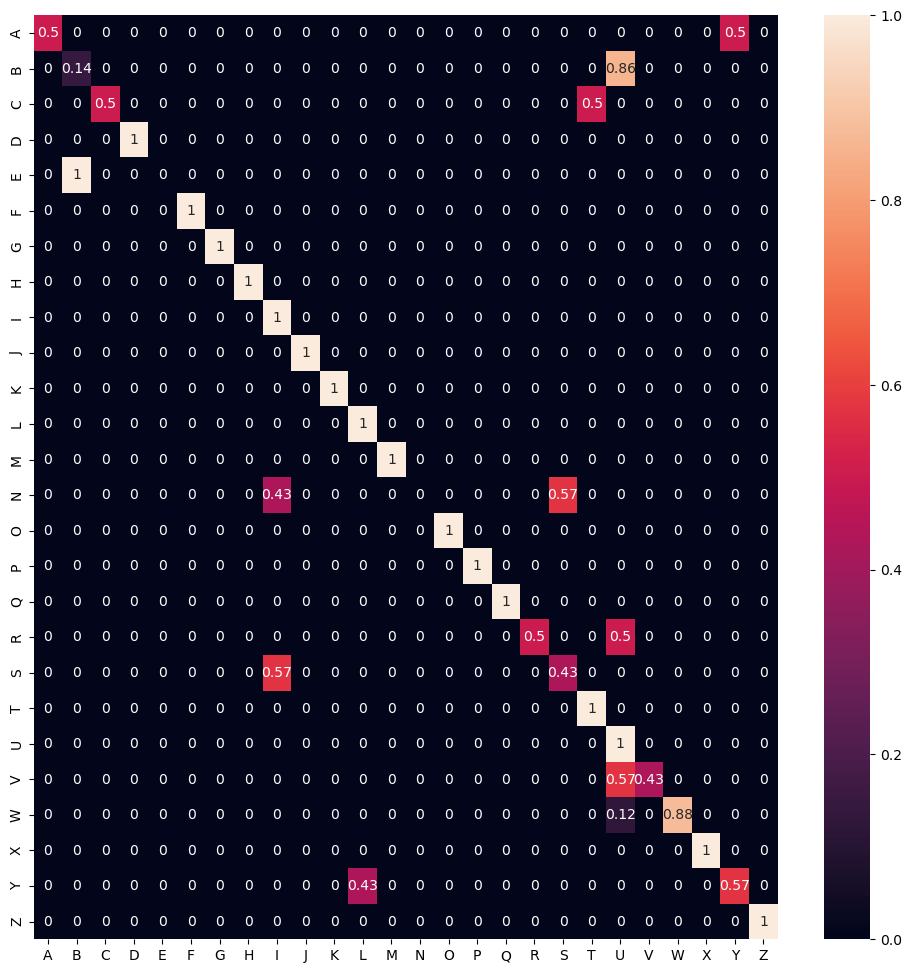

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import scienceplots
import seaborn as sn

cf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (12,12))
# sn.heatmap(df_cm, annot=True)
# plt.style.use('science')
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in ifd.classes],
                     columns = [i for i in ifd.classes])
sn.heatmap(df_cm, annot=True)
# ConfusionMatrixDisplay(cf_matrix).plot()

In [13]:
from sklearn.metrics import f1_score, precision_score, recall_score, f1_score

print("Precision Score : ",precision_score(y_true, y_pred, 
                                           pos_label='positive',
                                           average='micro'))
print("Recall Score : ",recall_score(y_true, y_pred, 
                                           pos_label='positive',
                                           average='micro'))
print("F1 Score : ",f1_score(y_true, y_pred, 
                                           pos_label='positive',
                                           average='micro'))

Precision Score :  0.765625
Recall Score :  0.765625
F1 Score :  0.765625


d:\miniconda\Lib\site-packages\sklearn\metrics\_classification.py:1583: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
d:\miniconda\Lib\site-packages\sklearn\metrics\_classification.py:1583: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
d:\miniconda\Lib\site-packages\sklearn\metrics\_classification.py:1583: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
